Autoregressive integrated moving average

In [40]:
import pandas as pd
import numpy as np

In [41]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

sns.set(context='notebook', style='whitegrid', rc={"figure.figsize": (18,4)})

In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [44]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 18,4

In [45]:
# to get rid of the unnecessary statsmodels package warnings
import warnings
warnings.filterwarnings("ignore")

In [46]:
# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## Processing the Data
We'll need to do some quick processing to convert this data to have a time series index. Luckily Pandas makes this easy, let's quickly check the head of the data (the first 5 rows) to see what default format it comes in:

In [47]:
dataset = pd.read_csv("SNP500Dataset.csv")
dataset = dataset.drop(columns=['Unnamed: 0'])  
dataset.head()

,Date,SNP500_High,SNP500_Low,Bitcoin_High,Bitcoin_Low,Oil_High,Oil_Low,Gold_High,Gold_Low,EURO_To_USD_Rate,Interest
0,2022-11-25,4034.02,4020.76,16481.4,16060.8,79.89,76.23,1761.2,1745.9,1.0402,1.41
1,2022-11-23,4033.78,3998.66,16595.4,16414.6,81.95,76.83,1754.9,1719.0,1.0418,1.41
2,2022-11-22,4005.88,3956.88,16686.3,16387.9,82.36,79.86,1751.0,1737.6,1.0310,1.41
3,2022-11-21,3962.00,3933.34,16611.8,16360.9,80.30,75.08,1755.0,1733.9,1.0245,1.41
4,2022-11-18,3979.89,3935.98,16785.6,16472.0,82.64,77.24,1769.9,1749.2,1.0324,1.41


In [48]:
dataset.isnull().values.any()

False

Right now our index is actually just a list of auto-generated numbers, we'll want to adjust these to be timestamps, that way our forecasting analysis will be able to interpret these values:

In [49]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index(keys=['Date'], drop=True, inplace=True)
dataset.sort_values(by='Date', ascending=False)

,SNP500_High,SNP500_Low,Bitcoin_High,Bitcoin_Low,Oil_High,Oil_Low,Gold_High,Gold_Low,EURO_To_USD_Rate,Interest
Date,,,,,,,,,,
2022-11-25,4034.02,4020.76,16481.4,16060.8,79.89,76.23,1761.2,1745.9,1.0402,1.41
2022-11-23,4033.78,3998.66,16595.4,16414.6,81.95,76.83,1754.9,1719.0,1.0418,1.41
2022-11-22,4005.88,3956.88,16686.3,16387.9,82.36,79.86,1751.0,1737.6,1.0310,1.41
2022-11-21,3962.00,3933.34,16611.8,16360.9,80.30,75.08,1755.0,1733.9,1.0245,1.41
2022-11-18,3979.89,3935.98,16785.6,16472.0,82.64,77.24,1769.9,1749.2,1.0324,1.41
...,...,...,...,...,...,...,...,...,...,...
2015-01-08,2064.08,2030.61,2757.3,2623.2,49.65,47.73,1216.4,1206.9,1.1793,0.13
2015-01-07,2029.61,2005.55,2804.4,2624.4,49.31,46.83,1217.5,1210.0,1.1839,0.13
2015-01-06,2030.25,1992.44,2800.5,2614.0,50.37,47.55,1222.0,1206.0,1.1889,0.13


In [50]:
for i in dataset.columns:
    dataset[i] = dataset[i].apply(lambda x : x if x > 0 else 0.01)

In [51]:
dataset.head()

,SNP500_High,SNP500_Low,Bitcoin_High,Bitcoin_Low,Oil_High,Oil_Low,Gold_High,Gold_Low,EURO_To_USD_Rate,Interest
Date,,,,,,,,,,
2022-11-25,4034.02,4020.76,16481.4,16060.8,79.89,76.23,1761.2,1745.9,1.0402,1.41
2022-11-23,4033.78,3998.66,16595.4,16414.6,81.95,76.83,1754.9,1719.0,1.0418,1.41
2022-11-22,4005.88,3956.88,16686.3,16387.9,82.36,79.86,1751.0,1737.6,1.0310,1.41
2022-11-21,3962.00,3933.34,16611.8,16360.9,80.30,75.08,1755.0,1733.9,1.0245,1.41
2022-11-18,3979.89,3935.98,16785.6,16472.0,82.64,77.24,1769.9,1749.2,1.0324,1.41


### Visualize the Time Series:

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'SNP500 High and Low from 2015 to 2022')

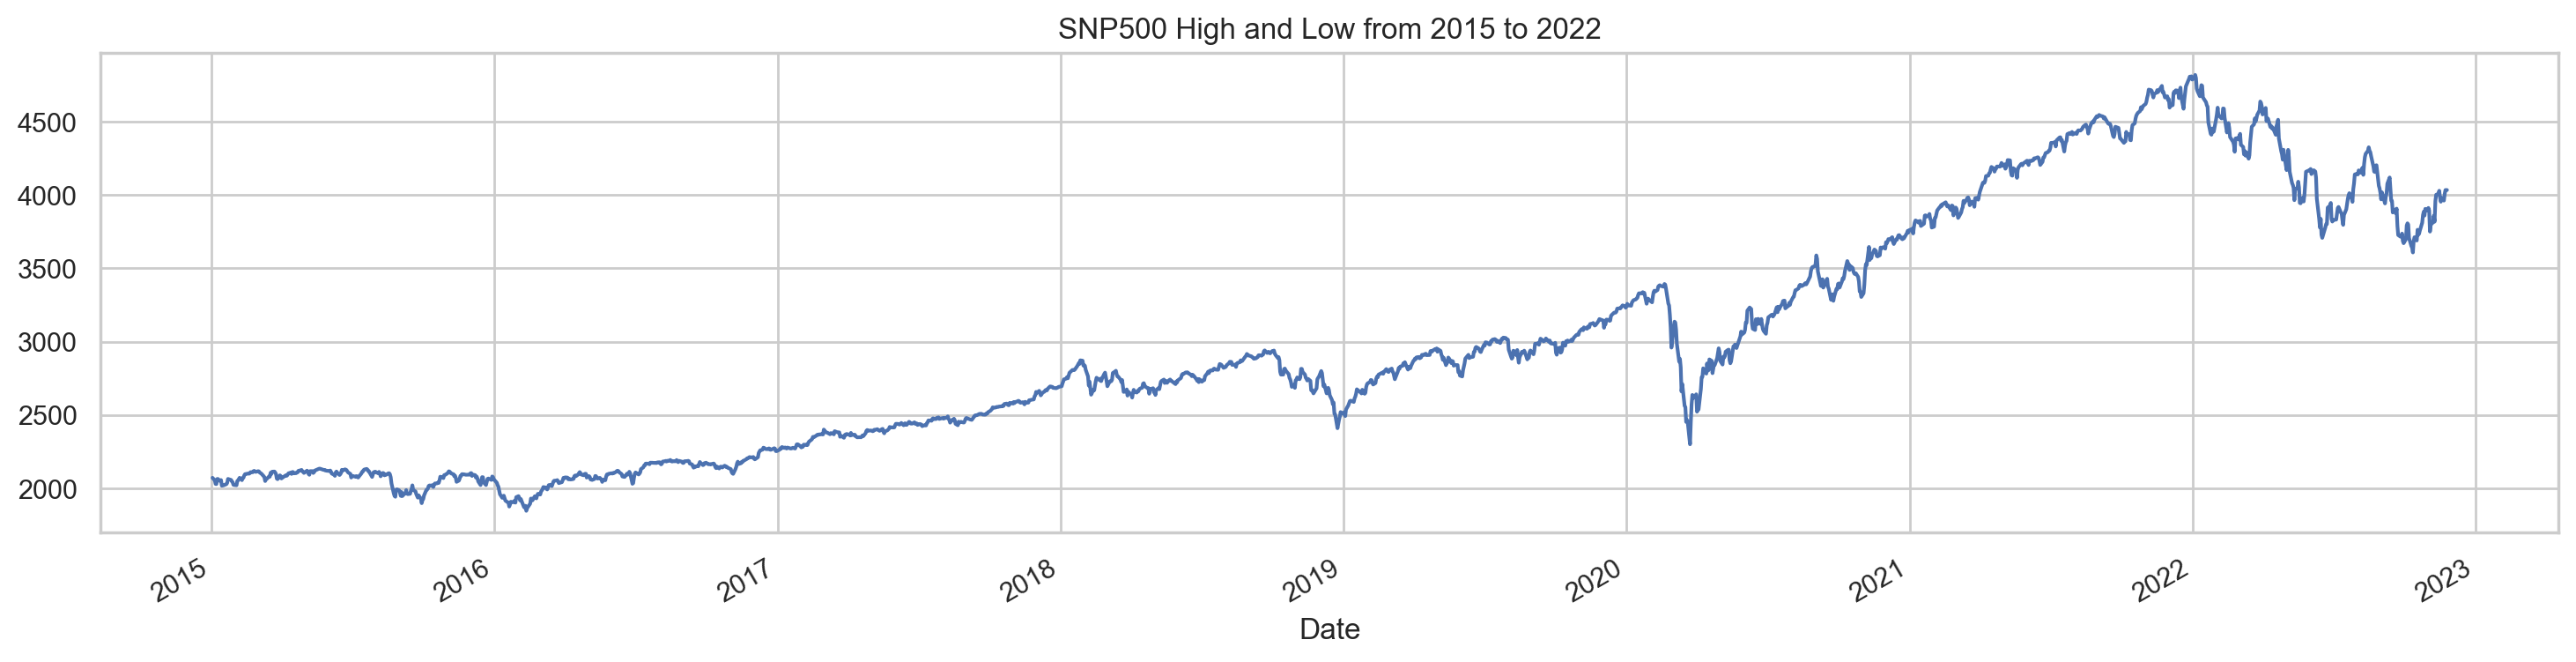

In [52]:

dataset['SNP500_High'].plot()
plt.title("SNP500 High and Low from 2015 to 2022")

### Decomposition

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset['SNP500_High'], model='multiplicative', period = 30)

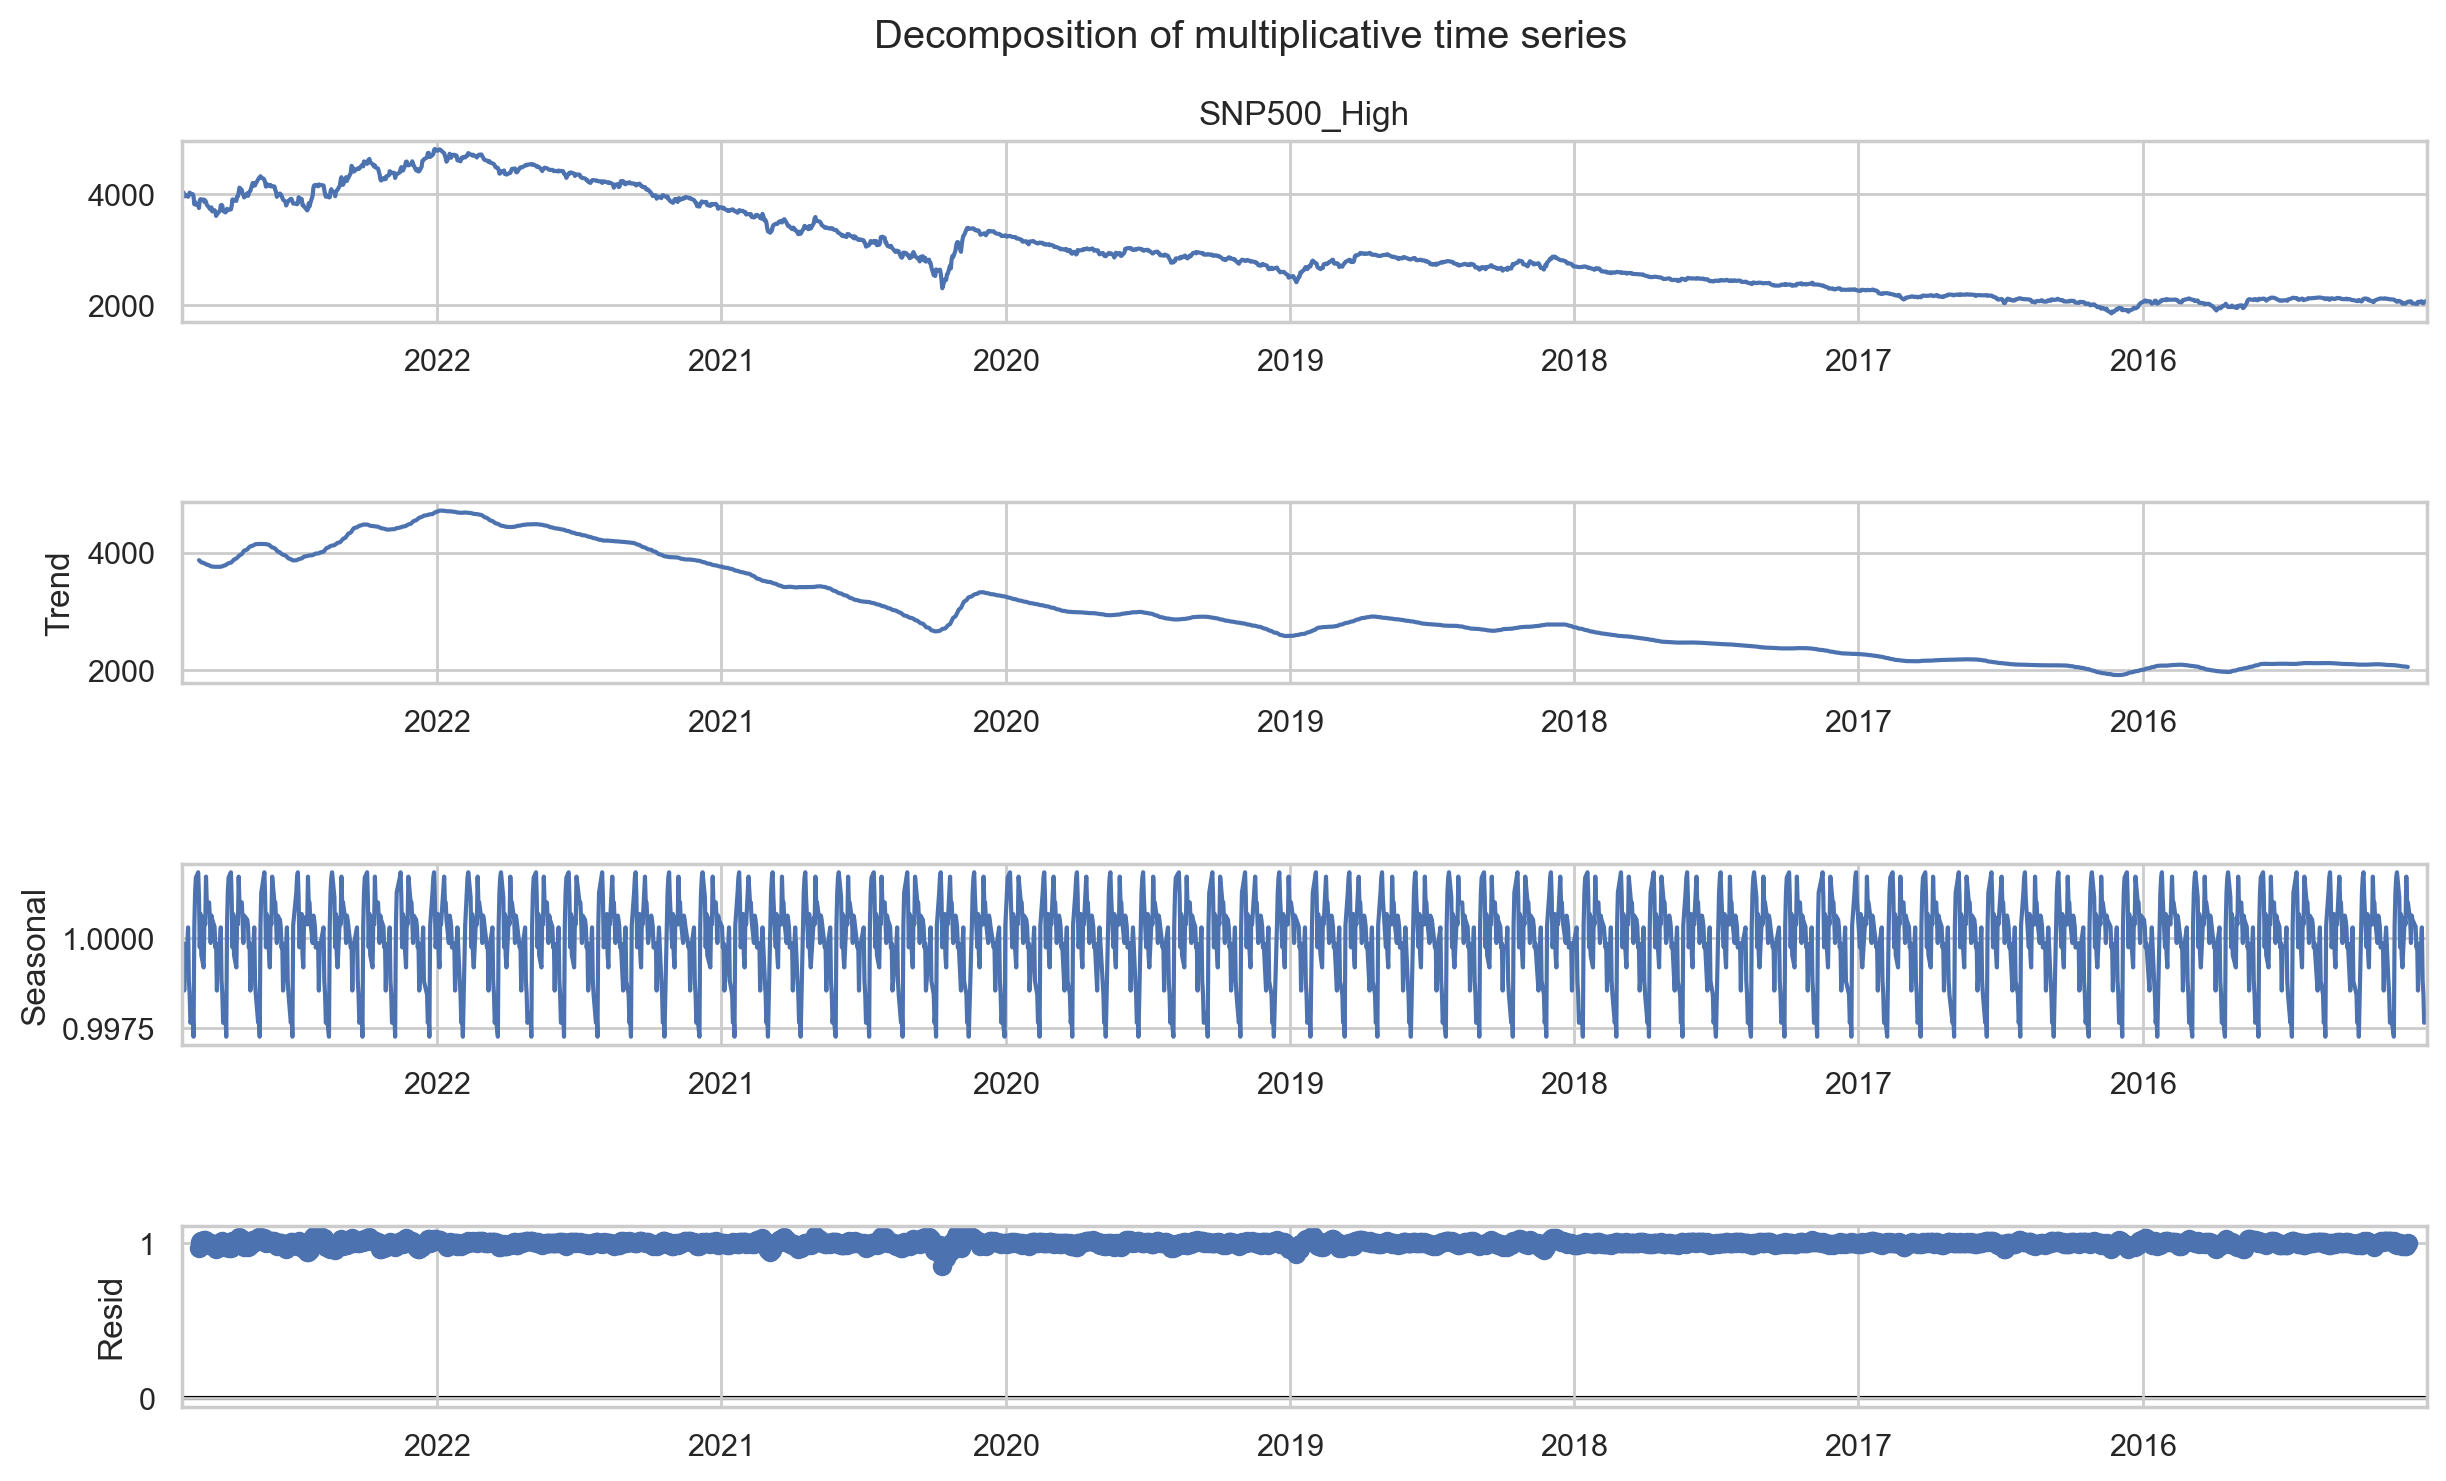

In [54]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series');

In [55]:
from pmdarima import auto_arima

In [56]:
stepwise_model = auto_arima(dataset['SNP500_High'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=20235.706, Time=0.22 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=19619.061, Time=1.62 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=20211.222, Time=0.30 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=19331.819, Time=2.94 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=11.04 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=6.95 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=19361.649, Time=2.39 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=19333.679, Time=4.15 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=19333.731, Time=4.74 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=19333.095, Time=3.98 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=19334.819, Time=7.47 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=19333.801, Time=10.01 sec

Best model:  ARIMA(1,1,0)(

In [57]:
stepwise_model.aic()

19331.81896684289

The resulting best model parameters gave us an AIC value of 1771.29.

We now have a model that we can fit, in order to do this , we will need training data and test data.

## Train Test Split
We can then fit the stepwise_model object to a training data set. Because this is a time series forecast, we will "chop off" a portion of our latest data and use that as the test set. Then we will train on the rest of the data and forecast into the future. Afterwards we can compare our forecast with the section of data we chopped off.

We'll train on 20 years of data, from the years 1985 - 2015 and test our forecast on the years after that and compare it to the real data:

In [58]:
train = dataset['SNP500_High'].loc['2015-01-01':'2020-01-01']

In [59]:
train.tail()

Date
2015-01-08    2064.08
2015-01-07    2029.61
2015-01-06    2030.25
2015-01-05    2054.44
2015-01-02    2072.36
Name: SNP500_High, dtype: float64

In [60]:
test = dataset['SNP500_High'].loc['2020-01-01':]

In [61]:
test.head()

Date
2022-11-25    4034.02
2022-11-23    4033.78
2022-11-22    4005.88
2022-11-21    3962.00
2022-11-18    3979.89
Name: SNP500_High, dtype: float64

In [62]:
test.tail()

Date
2020-01-08    3267.07
2020-01-07    3244.91
2020-01-06    3246.84
2020-01-03    3246.15
2020-01-02    3258.14
Name: SNP500_High, dtype: float64

## Train the Model
We can then train the model by simply calling `.fit` on the stepwise model and passing in the training data:

In [63]:
len(train), len(test)

(1258, 732)

In [64]:
stepwise_model.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

## Evaluation
Now that the model has been fitted to the training data, we can forecast into the future. Recall that our test data set is from 2015-01-01 all the way to 2018-01-01. So if we check the length of our test data we get 37 rows, or 37 time periods. That is the value we will use for our `.predict()` method call:

In [65]:
test_predictions = stepwise_model.predict(n_periods=23)

In [66]:
test_predictions

array([2067.1592725 , 2058.89800393, 2057.91976704, 2044.83266282,
       2060.07012293, 2057.79454943, 2068.62108622, 2068.00452504,
       2053.65301319, 2055.00532483, 2061.13900897, 2063.70655909,
       2056.12683111, 2047.64427751, 2046.36378538, 2032.50583089,
       2051.9337897 , 2048.82255459, 2062.98780595, 2064.07163043,
       2049.43251304, 2051.62319464, 2062.62806563])

In [67]:
print(test.index)

DatetimeIndex(['2022-11-25', '2022-11-23', '2022-11-22', '2022-11-21',
               '2022-11-18', '2022-11-17', '2022-11-16', '2022-11-15',
               '2022-11-14', '2022-11-11',
               ...
               '2020-01-15', '2020-01-14', '2020-01-13', '2020-01-10',
               '2020-01-09', '2020-01-08', '2020-01-07', '2020-01-06',
               '2020-01-03', '2020-01-02'],
              dtype='datetime64[ns]', name='Date', length=732, freq=None)


Let's reorganize this set of predictions by creating a dataframe that contains our future forecast and then concatenating that with the original data.

We can then plot this to view how well our prediction forecast matched up with the test set for which we have the real data:

In [68]:
test_predictions = pd.DataFrame(test_predictions, columns=['Prediction'])

In [69]:
test_predictions.head()

,Prediction
0,2067.159272
1,2058.898004
2,2057.919767
3,2044.832663
4,2060.070123


In [70]:
test.head()

Date
2022-11-25    4034.02
2022-11-23    4033.78
2022-11-22    4005.88
2022-11-21    3962.00
2022-11-18    3979.89
Name: SNP500_High, dtype: float64

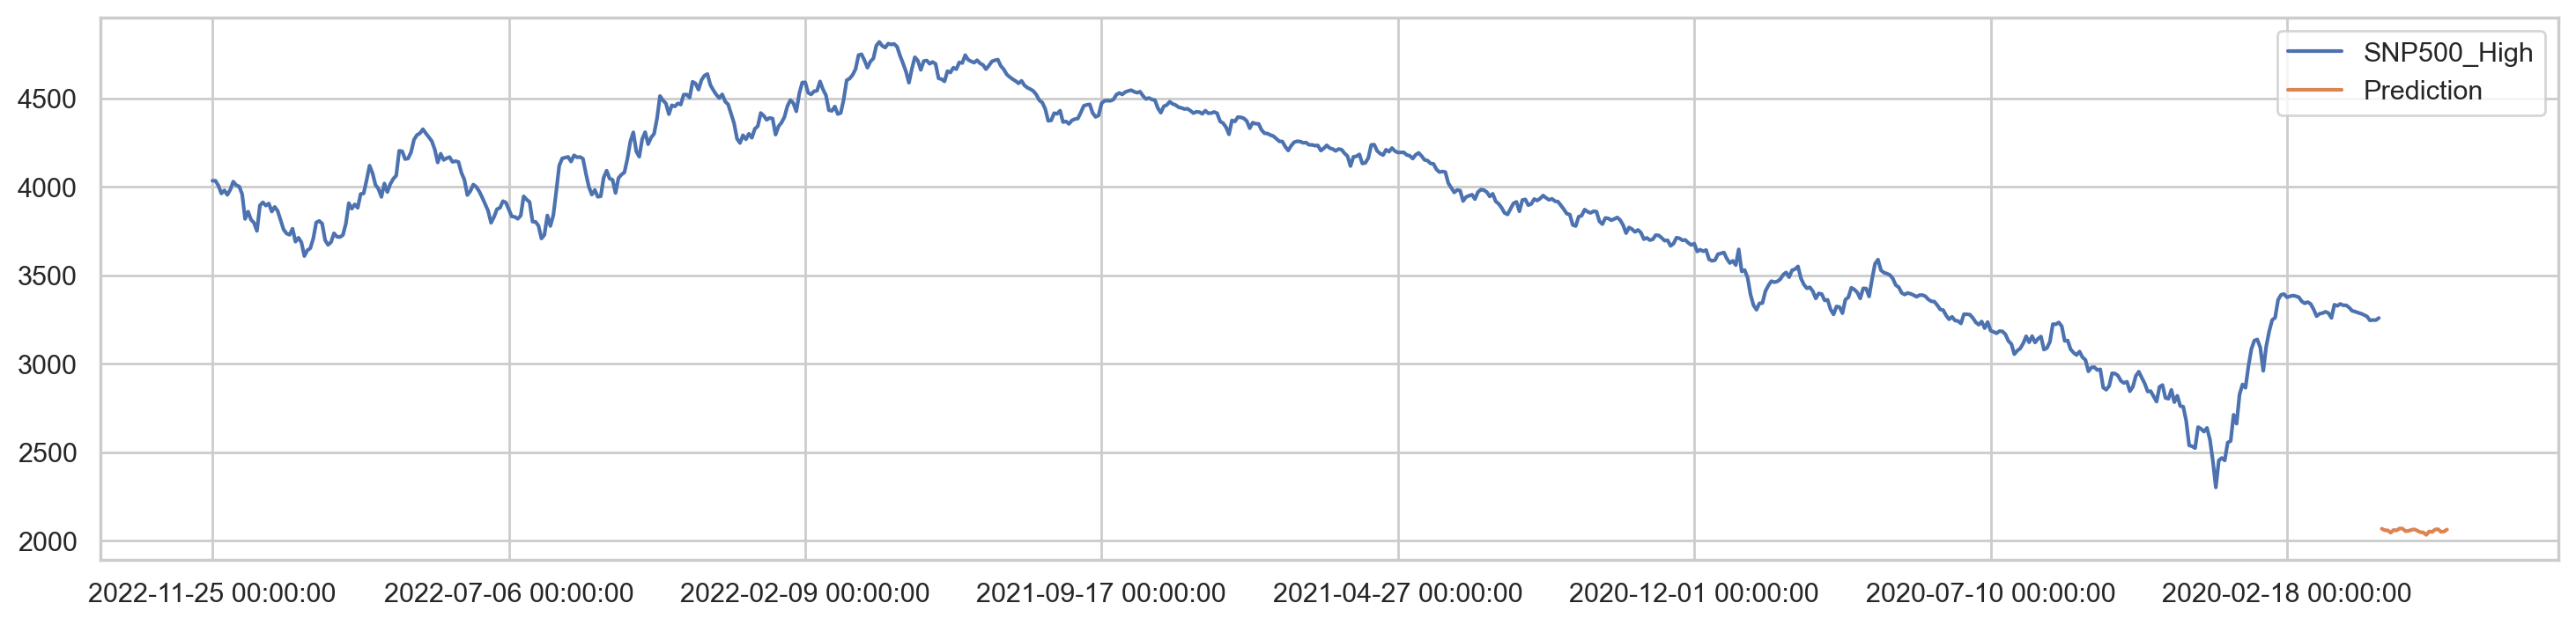

In [71]:
pd.concat([test, test_predictions], axis=1).plot();

We can also just compare this to the entire data set to get a larger picture of the context of our prediction.

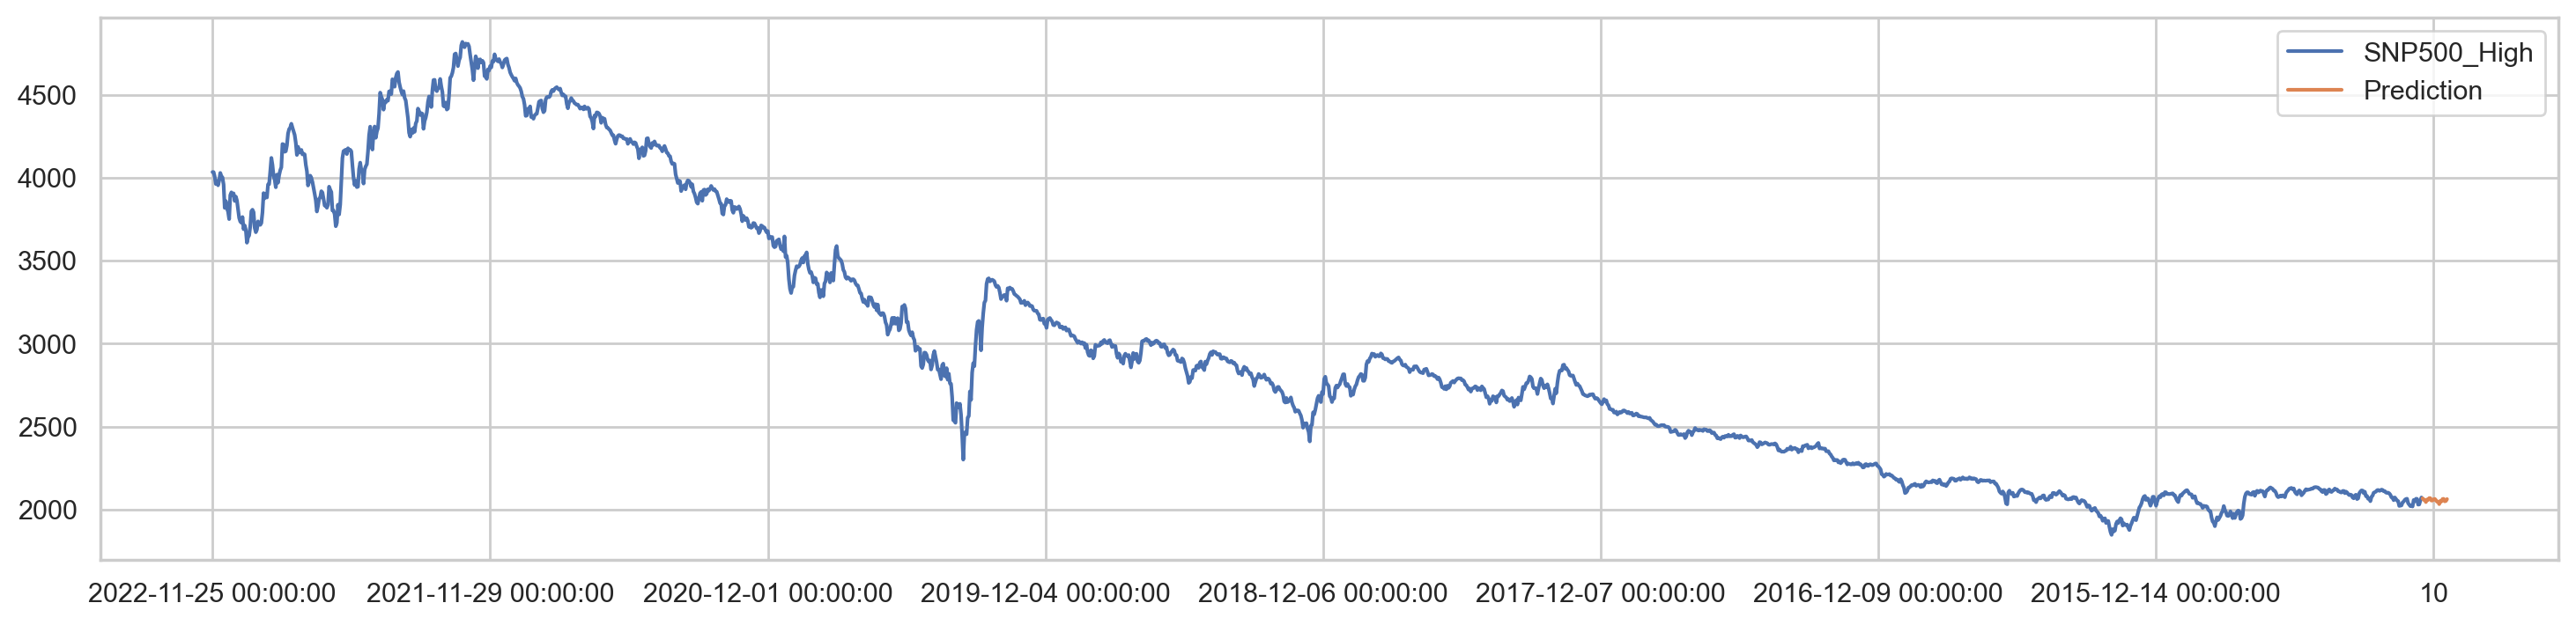

In [72]:
pd.concat([dataset['SNP500_High'], test_predictions], axis=1).plot();

## Next Steps
Now that we've evaluated our data on the test set and our satisfied with the performance, the next step would be to refit our model to our entire data set and then forecast into the real future. We will predict in future for 36 months.

In [73]:
future_forecast = stepwise_model.fit(dataset['SNP500_High']).predict(n_periods=100)

In [74]:
future_index = pd.date_range(start=dataset.index[-1] + pd.DateOffset(days=1), periods=100, freq='MS')
future_index

DatetimeIndex(['2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
               '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
      

In [75]:
future_forecast = pd.DataFrame(future_forecast, index=future_index, columns=['Prediction'])

In [76]:
pd.concat([dataset['SNP500_High'], future_forecast], axis=1).tail()

,SNP500_High,Prediction
2023-01-01,NaN,2039.378769
2023-02-01,NaN,2032.708825
2023-03-01,NaN,2024.366957
2023-04-01,NaN,2023.439027
2023-05-01,NaN,2010.926816


<AxesSubplot:>

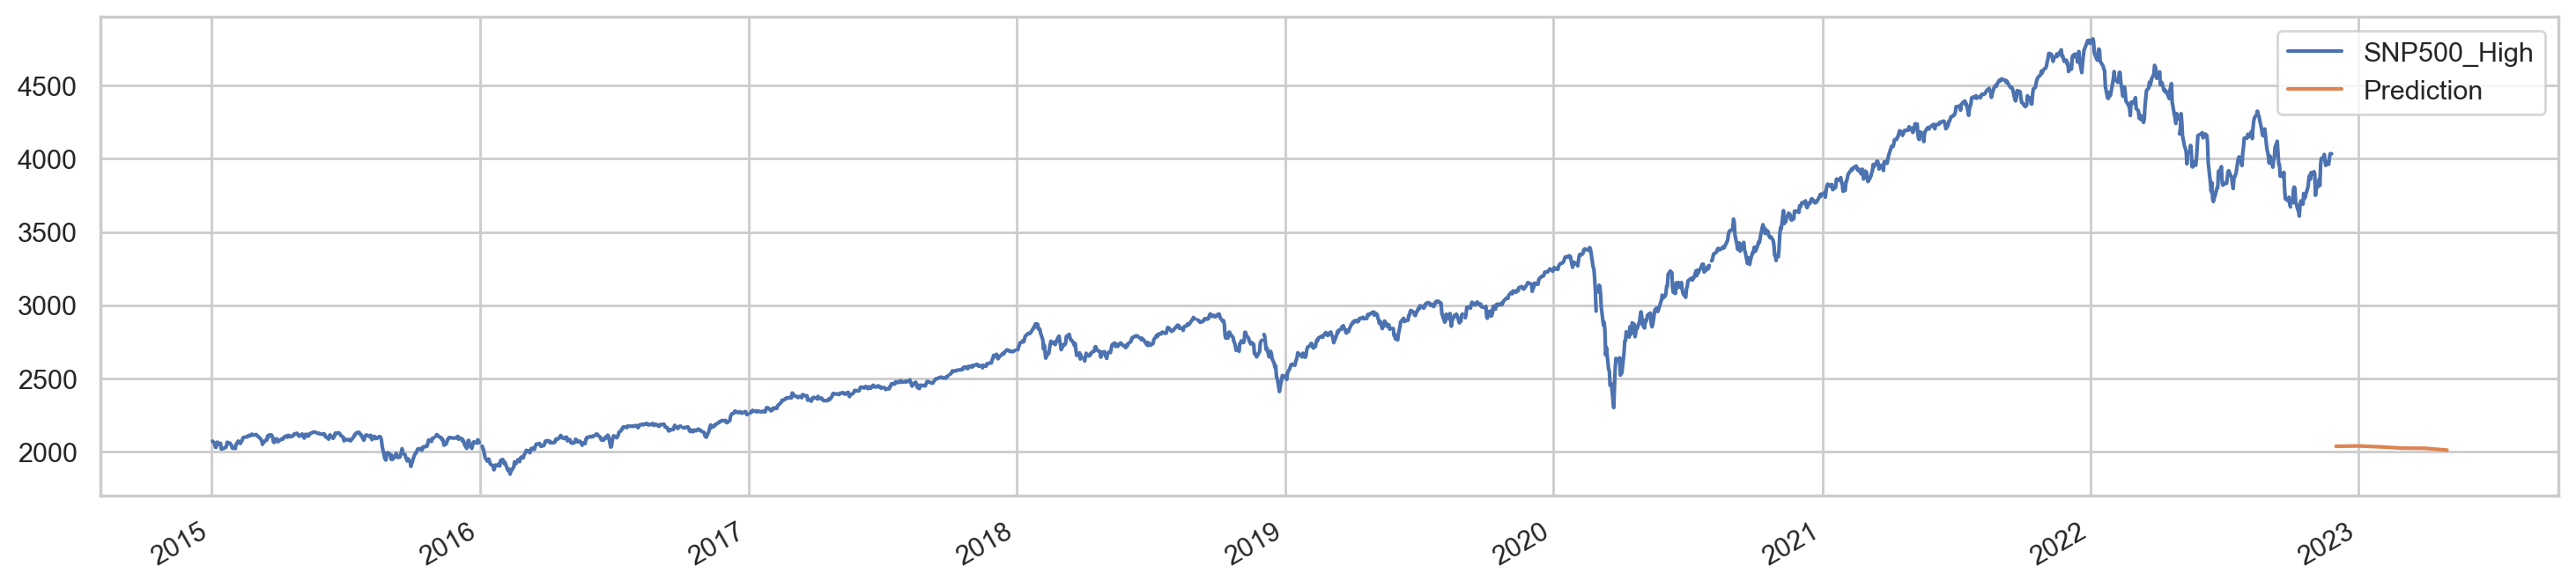

In [77]:
pd.concat([dataset['SNP500_High'], future_forecast], axis=1).plot()